# MNIST Example in PyTorch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# Set device
os.chdir('/home/shiyao/CNN_MNIST')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


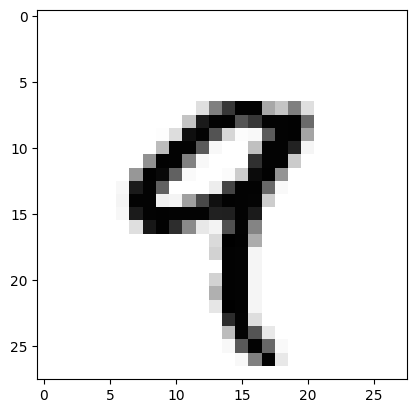

In [3]:
# Data Loading and Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data/MNIST', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data/MNIST', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Visualize one of the digits
first_image, _ = train_dataset[4]
plt.imshow(first_image.squeeze().numpy(), cmap=plt.cm.Greys);
plt.show()



In [4]:

# Define the Model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, num_classes)
#97.31 256
#97.41 512
#97.31 128
#96.40 64
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model
input_dim = 28 * 28
num_classes = 10
model = NeuralNetwork(input_dim, num_classes).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer, num_epochs=10)

# Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

evaluate_model(model, test_loader)


Epoch [1/10], Loss: 0.5926
Epoch [2/10], Loss: 0.3765
Epoch [3/10], Loss: 0.3489
Epoch [4/10], Loss: 0.3349
Epoch [5/10], Loss: 0.3256
Epoch [6/10], Loss: 0.3197
Epoch [7/10], Loss: 0.3128
Epoch [8/10], Loss: 0.3090
Epoch [9/10], Loss: 0.3046
Epoch [10/10], Loss: 0.3037
Test Accuracy: 90.59%


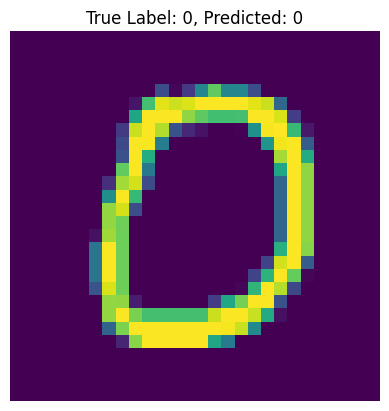

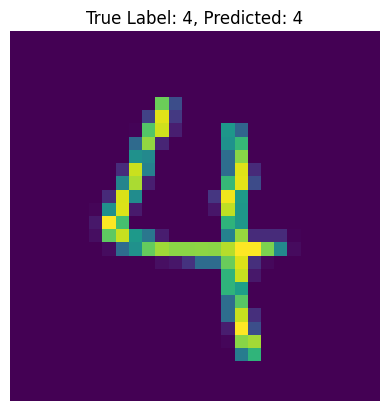

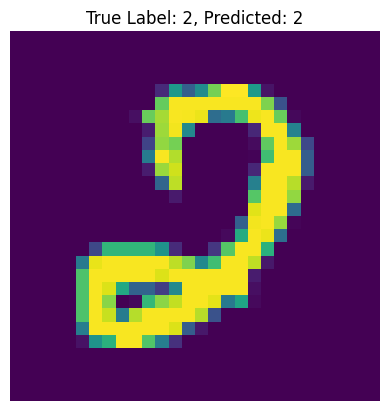

In [5]:
def predict_images(model, dataset, indices, transform=None):
    """
    Predict specific images based on global dataset indices.
    Args:
        model: Trained PyTorch model.
        dataset: Dataset to fetch images from (e.g., test_dataset_CIFAR10).
        indices: List of global indices to visualize and predict.
        transform: Any additional transformation (if necessary).
    """
    model.eval()
    for idx in indices:
        # Get image and label from the dataset
        image, label = dataset[idx]
        if transform:
            image = transform(image)
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Perform prediction
        with torch.no_grad():
            output = model(image)
            _, prediction = output.max(1)

        # Visualize the image
        plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)  # Unnormalize
        plt.title(f"True Label: {label}, Predicted: {prediction.item()}")
        plt.axis('off')
        plt.show()

# Example Usage
predict_images(model, test_dataset, [10, 24, 400])


In [8]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Input: 1 channel, 32 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Input: 32 channels, 64 filters
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample by 2
        self.fc1 = nn.Linear(64 * 14 * 14, 512)  # Corrected input size
        self.fc2 = nn.Linear(512, num_classes)  # Output layer

    def forward(self, x):
        x = F.relu(self.conv1(x))       # Apply ReLU after first conv
        x = self.pool(F.relu(self.conv2(x)))  # Apply ReLU after second conv and then pool
        x = x.view(x.size(0), -1)       # Flatten the tensor for fully connected layers
        x = F.relu(self.fc1(x))         # Apply ReLU after first fully connected layer
        x = self.fc2(x)                 # Output layer (no activation; handled by loss function)
        return x

# Initialize and use the CNN model
num_classes = 10  # For MNIST
CNN_model = CNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN_model.parameters(), lr=0.001)  # Corrected to CNN_model

def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computation for efficiency
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

# Train for 5 epochs
num_epochs = 5
train_model(CNN_model, train_loader, criterion, optimizer, num_epochs=num_epochs)

# Evaluate the model
evaluate_model(CNN_model, test_loader)

Epoch [1/5], Loss: 0.1090
Epoch [2/5], Loss: 0.0347
Epoch [3/5], Loss: 0.0200
Epoch [4/5], Loss: 0.0148
Epoch [5/5], Loss: 0.0097
Accuracy of the model on the test images: 98.85%
